# 프로젝트 1 : 직접 고른 이미지로 SRGAN 실험하기


## 프로젝트 1-1.

1. (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.
2. 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄입니다. cv2.resize()를 사용해 봅시다.
3. 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.
4. 2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. 마찬가지로 cv2.resize()를 사용해 봅시다.
5. 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.
6. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)

## 고양이 사진

(796, 877, 3)


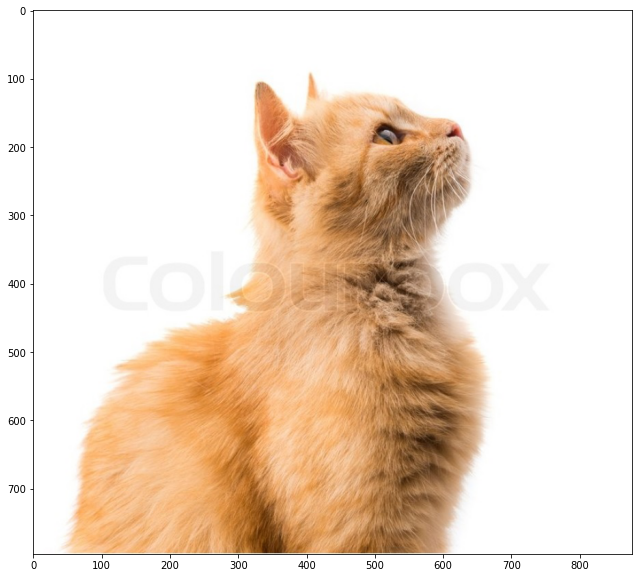

In [1]:
import matplotlib.pyplot as plt

hr_image = plt.imread("cat.jpg")
hr_shape = hr_image.shape[:2]

print(hr_image.shape) # 이미지의 크기를 출력합니다.
origin_image_shape = (hr_image.shape[1],hr_image.shape[0])

plt.figure(figsize=(12,10))
plt.imshow(hr_image)

(199, 219, 3)


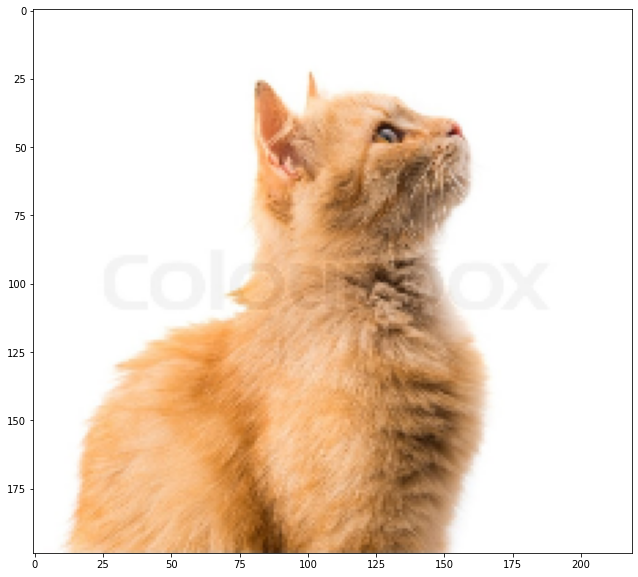

In [2]:
import cv2
lr_image = cv2.resize(hr_image, dsize=(origin_image_shape[0]//4,origin_image_shape[1]//4)) # (가로 픽셀 수, 세로 픽셀 수)

print(lr_image.shape)

plt.figure(figsize=(12,10))
plt.imshow(lr_image)

## Super Resolution - Interpolation 활용 

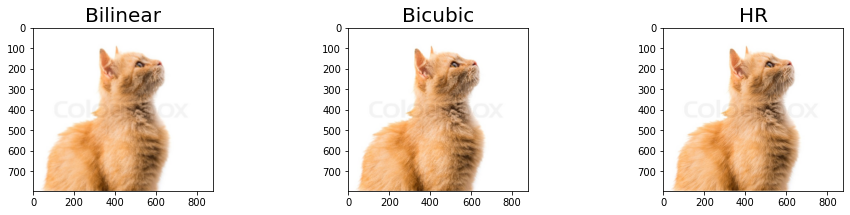

In [3]:
bilinear_image = cv2.resize(
    lr_image, 
    dsize=origin_image_shape, # (가로 픽셀 수, 세로 픽셀 수) 
    interpolation=cv2.INTER_LINEAR # bilinear interpolation 적용
)

bicubic_image = cv2.resize(
    lr_image, 
    dsize=(origin_image_shape[0],origin_image_shape[1]), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

images = [bilinear_image, bicubic_image, hr_image]
titles = ["Bilinear", "Bicubic", "HR"]

plt.figure(figsize=(16,3))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

* 이미지를 작게 봐서 그런지 별 차이를 모르겠다. crop함수를 통해 확대해서 봐보자

[(600, 100), (600, 100), (600, 100), (100, 300), (100, 300), (100, 300), (150, 500), (150, 500), (150, 500)]


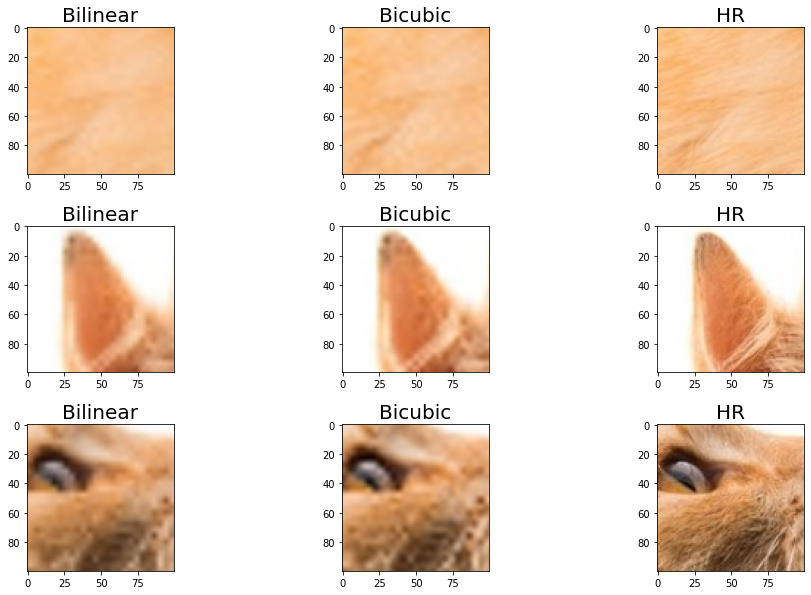

In [4]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=100, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]


# 잘라낼 영역의 좌표를 정의합니다.
left_tops = [(600,100)] *3 + [(100,300)] *3 + [(150,500)] *3
print(left_tops)
plt.figure(figsize=(16,10))
for i, (image, left_top, title) in enumerate(zip(images*3, left_tops, titles*3)):
    plt.subplot(3,3,i+1)
    plt.subplots_adjust(hspace = 0.35)
    plt.imshow(crop(image, left_top))
    plt.title(title, fontsize=20)

원본이미지의 해상도(2000,1500) -> 저해상도(1/4 사이즈)로 변경을 해서 그런지 보간을 통해 SR기법을 적용해도 원본이미지만큼 복원이 되지는 않고 있다. 

특히나 작게 쓰여진 글씨는 HR이미지만큼 복구가 안된다.

## Super Resolution - SRGAN 활용 

In [5]:
import tensorflow as tf
import os

model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [6]:
import numpy as np
import tensorflow_datasets as tfds

def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)

for i, (lr, hr) in enumerate(valid):
    if i == 6: break

srgan_hr = apply_srgan(lr_image)
print("✅")

✅


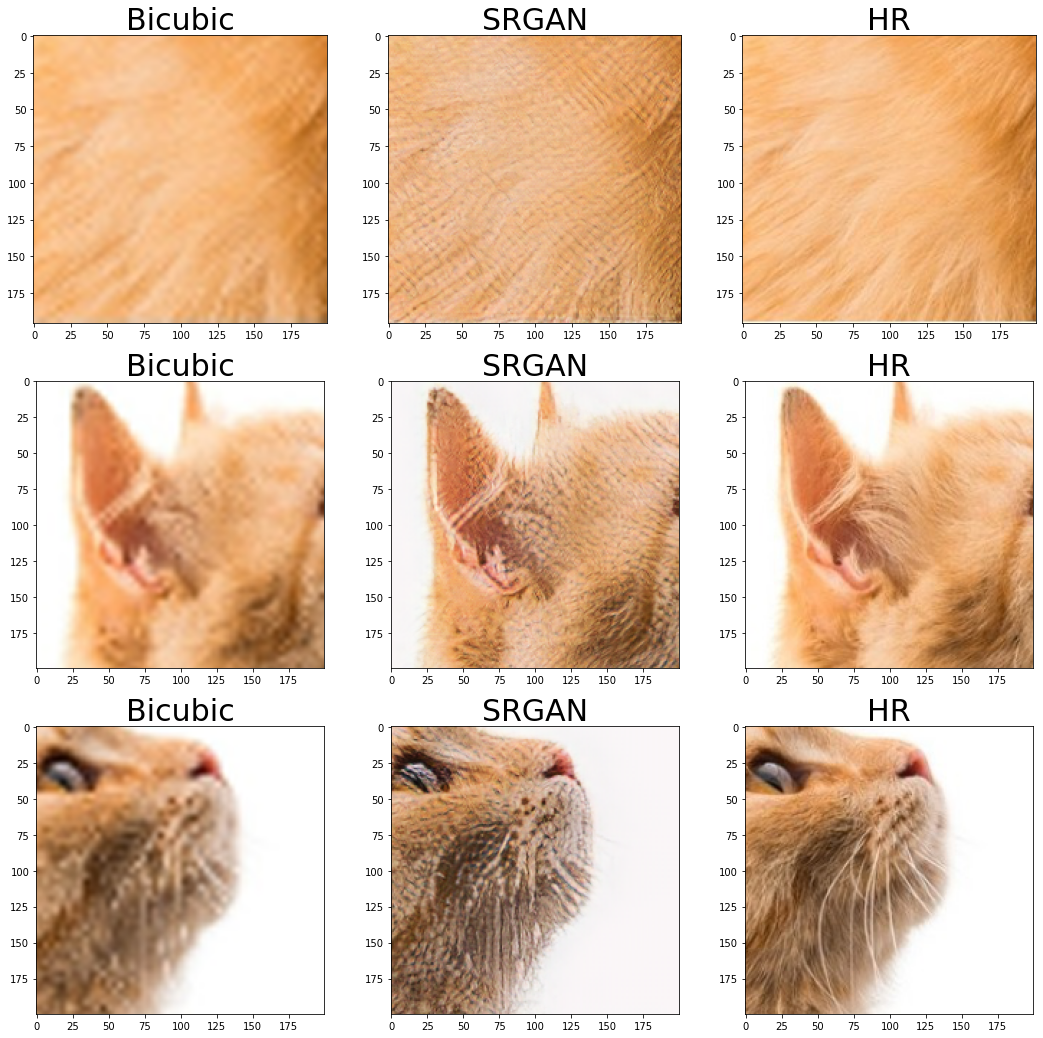

In [7]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(600,100), (100,300), (150,500)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_image, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    img3 = crop(hr_image, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

HR 이미지의 경우 털 가닥가닥이 모두 선명하게 표현됨

SRGAN의 경우 학습한 모델을 이용해 추측을하려 노력한 것 같지만 약간 아쉬운 느낌이 있음

Bicubic은 단순한 보간 방법을 사용했기 때문에 모자이크처리된 이미지처럼 나옴

## 프로젝트 1-2.

1. (적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.
2. 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.
3. 1.에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. cv2.resize()를 사용해 봅시다.
4. 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.
6. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)

## 풍경 사진

(750, 1334, 3)


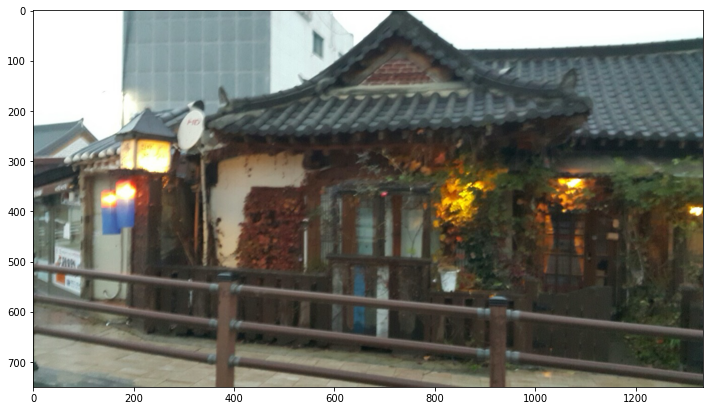

In [8]:
import matplotlib.pyplot as plt

hr_image = plt.imread("landscape.jpg")
hr_shape = hr_image.shape[:2]

print(hr_image.shape) # 이미지의 크기를 출력합니다.
origin_image_shape = (hr_image.shape[1],hr_image.shape[0])

plt.figure(figsize=(12,10))
plt.imshow(hr_image)

(187, 333, 3)


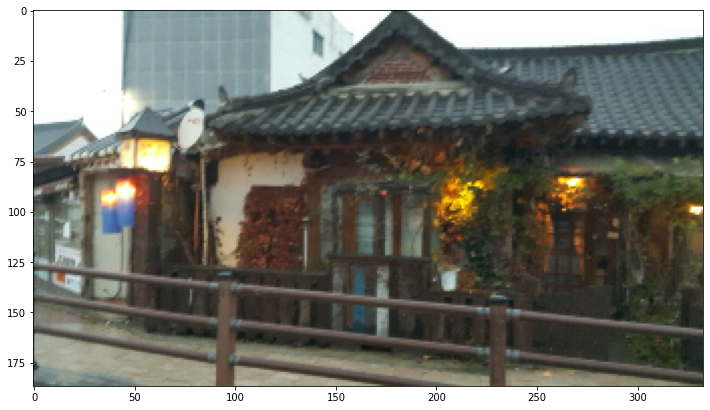

In [9]:
import cv2
lr_image = cv2.resize(hr_image, dsize=(origin_image_shape[0]//4,origin_image_shape[1]//4)) # (가로 픽셀 수, 세로 픽셀 수)

print(lr_image.shape)

plt.figure(figsize=(12,10))
plt.imshow(lr_image)

## Super Resolution - Interpolation 활용 

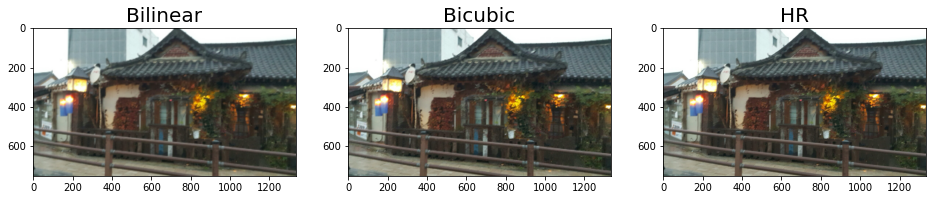

In [10]:
bilinear_image = cv2.resize(
    lr_image, 
    dsize=origin_image_shape, # (가로 픽셀 수, 세로 픽셀 수) 
    interpolation=cv2.INTER_LINEAR # bilinear interpolation 적용
)

bicubic_image = cv2.resize(
    lr_image, 
    dsize=(origin_image_shape[0],origin_image_shape[1]), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

images = [bilinear_image, bicubic_image, hr_image]
titles = ["Bilinear", "Bicubic", "HR"]

plt.figure(figsize=(16,3))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

* 이미지를 작게 봐서 그런지 별 차이를 모르겠다. crop함수를 통해 확대해서 봐보자

In [11]:
srgan_hr = apply_srgan(lr_image)
print("✅")

✅


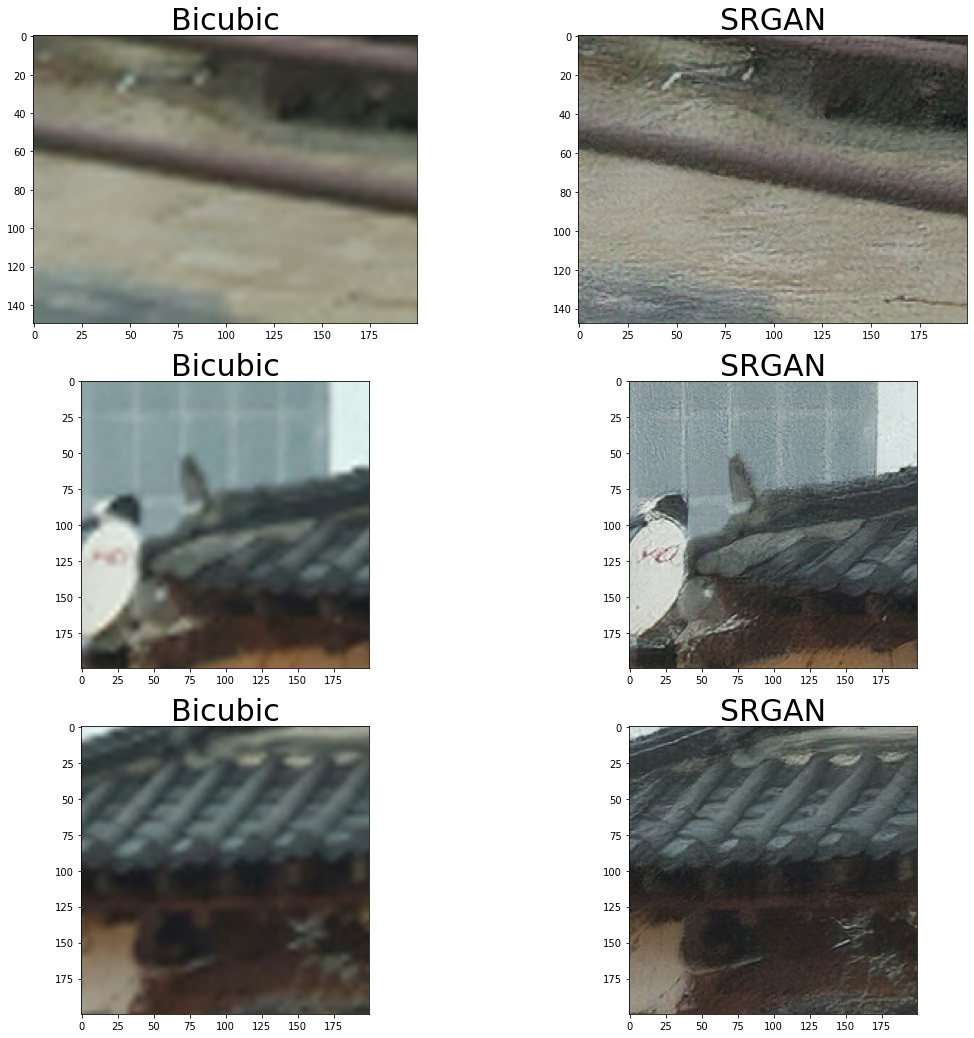

In [12]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(600,100), (100,300), (150,500)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_image, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    images.extend([img1, img2])

labels = ["Bicubic", "SRGAN"] * 3

plt.figure(figsize=(18,18))
for i in range(6):
    plt.subplot(3,2,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

SRGAN의 경우 저해상도 이미지를 오히려 더 선명하게 만들어주는 효과를 가져왔다. 

Bicubic은 단순한 보간 방법을 사용했기 때문에 기존의 저해상도 이미지보다 더 모자이크처리된 이미지처럼 나옴

# 프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성하기

## 1. gif 파일 불러오기

In [13]:
!pip install imageio

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [14]:
import cv2

# 다운받은 파일의 경로를 설정해 주세요.
gif = cv2.VideoCapture("metro_lr.gif")

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))
print(np.shape(frames))

frame 수 : 35
frame 크기 : (252, 282, 3)
(35, 252, 282, 3)


## 2. 프레임별 Super Resolution 진행하기

### 저해상도 gif -> 고해상도 gif  - SRGAN

In [15]:
frames_sr = []
for i in range(len(frames)//5):
    srgan_hr = apply_srgan(frames[i])
    frames_sr.append(srgan_hr)

### 저해상도 gif -> 고해상도 gif  - Bicubic 보간법

In [16]:
bicubic_list = []
lr_list = []
origin_image_shape = (frames[0].shape[1],frames[0].shape[0])
for i in range(len(frames)):
    lr_image = cv2.resize(frames[i], dsize=(frames[i].shape[0],frames[i].shape[1]))
    bicubic_image = cv2.resize(
    lr_image, 
    dsize=(origin_image_shape[0]*2,origin_image_shape[1]*2), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
    )
    bicubic_list.append(bicubic_image)
    lr_list.append(lr_image)
    

## 3. 프레임을 합쳐 gif 만들기


In [17]:
import imageio

imageio.mimsave("srgan_metro.gif", frames_sr)
imageio.mimsave("bicubic_metro.gif", bicubic_list)
imageio.mimsave("lr_metro.gif", lr_list)

## 4. Jupyter notebook에 gif 표시하기

### 저해상도 metro gif

![원본](/GAN/gif/metro_lr.gif)

### SRGAN metro gif

![원본](/GAN/gif/srgan_metro.gif)

### Bicubic metro gif

![원본](/GAN/gif/bicubic_metro.gif)

# 결과 요약

1. SRGAN의 성능으로 기존의 저해상도 gif 파일을 선명하게 만듦.
    
    지하철,형광등, 기둥의 글자까지 모두 선명해진 것을 볼 수있다.
    
    
2. Bicubic은 2배의 사이즈로 키워서 보간을 해주었다. 4배의 경우도 진행해보았지만 대단한 성능 변화를 보지는 못했다.